### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [8]:
import datajoint as dj
import pandas as pd
import u19_pipeline.automatic_job.recording_handler as rec_handler
import u19_pipeline.automatic_job.recording_process_handler as rec_process_handler

from u19_pipeline import recording, recording_process

import u19_pipeline.ephys_pipeline as ephys_pipeline
from u19_pipeline.ephys_pipeline import  ephys_element

import u19_pipeline.imaging_pipeline as imaging_pipeline
from u19_pipeline.imaging_pipeline import  imaging_element, scan_element

ephys_pipeline = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')
ephys_element = dj.create_virtual_module('ephys_element', 'u19_pipeline_ephys_element')


imaging_pipeline = dj.create_virtual_module('imaging_pipeline', 'u19_imaging_pipeline')
scan_element = dj.create_virtual_module('scan_element', 'u19_pipeline_scan_element')
imaging_element = dj.create_virtual_module('imaging_element', 'u19_pipeline_imaging_element')




### Run recording main pipeline

In [3]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

### Run recording_prcoess main pipeline

In [11]:
l = rec_process_handler.RecProcessHandler.pipeline_handler_main()

scp u19_pipeline/automatic_job/ParameterFiles/process_paramset_68.json alvaros@tigergpu.princeton.edu:/tiger/scratch/gpfs/BRAINCOGS/ParameterFiles/process_paramset_68.json
1
update_dict {'value_update': None, 'error_info': {'error_message': None, 'error_exception': None}}


### Insert cat_gt params 1 & 2

In [6]:
cat_gt_params =  {
      "apfilter": ["biquad",2,300,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"]
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=0,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort2')


cat_gt_params =  {
      "apfilter": ["biquad",2,301,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"]
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=1,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort2')


ephys_element.PreClusterParamSet()
 


paramset_idx,precluster_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,catgt,Spike sorting using Kilosort2,4271fe75-1732-5821-0070-45b4c286e867,=BLOB=
1,catgt2,Spike sorting using Kilosort2,3d1047b9-deec-bc7f-d5a5-4e30c1665f07,=BLOB=


### Insert precluster_param_lists

In [10]:
paramlist = {'precluster_param_list_id':0}
ephys_element.PreClusterParamList.insert1(paramlist, skip_duplicates=True)

paramorder = {
'precluster_param_list_id': 0,
'order_id': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder, skip_duplicates=True)


paramlist = {'precluster_param_list_id':1}
ephys_element.PreClusterParamList.insert1(paramlist, skip_duplicates=True)

paramorder = {
'precluster_param_list_id': 1,
'order_id': 1,
'paramset_idx': 1
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder, skip_duplicates=True)


paramlist = {'precluster_param_list_id':2}
ephys_element.PreClusterParamList.insert1(paramlist,skip_duplicates=True)

paramorder = {
'precluster_param_list_id': 2,
'order_id': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder, skip_duplicates=True)
paramorder = {
'precluster_param_list_id': 2,
'order_id': 2,
'paramset_idx': 1
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder, skip_duplicates=True)

ephys_element.PreClusterParamList.ParamOrder()


precluster_param_list_id,order_id Order of operations,paramset_idx
0,1,0
2,1,0
1,1,1
2,2,1


### Insert cluster_paramsets

In [12]:
params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 1,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=0,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')


params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 2,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=1,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')


ephys_element.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,b9e07e55-95ea-3463-a740-90291de41da6,=BLOB=
1,kilosort2,Spike sorting using Kilosort2,697d24ac-2d46-a6e8-6f6b-2d1afaea000d,=BLOB=


### Insert defaultParmas table for some recordings

In [14]:

# For recording 39, all probes equal, list = 0
default_params_key = dict()
default_params_key['recording_id'] = 39
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

# For recording 41, all probes equal, list = 2   (list 2 has two different preparams catgt & catgt2)
default_params_key = dict()
default_params_key['recording_id'] = 41
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 2
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

# For recording 40, all probes different params
default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 0
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 1
default_params_key['pre_param_list_id'] = 0
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 2
default_params_key['pre_param_list_id'] = 1
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 3
default_params_key['pre_param_list_id'] = 1
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

recording.DefaultParams()


recording_id Unique number assigned to recording,fragment_number probe/field_of_view # if not always the same,default_same_preparams_all by default all probes/fields of view have same preparameters,pre_param_list_id preparams index for recording (could be imaging/ephys),default_same_params_all by default all probes/fields of view have same parameters,paramset_idx params index for recording (could be imaging/ephys)
37,0,1,0,1,0
39,0,1,0,1,0
40,0,0,0,0,0
40,1,0,0,0,1
40,2,0,1,0,0
40,3,0,1,0,1
41,0,1,2,1,0


## "Simplified" Ephys diagram and Imaging diagram

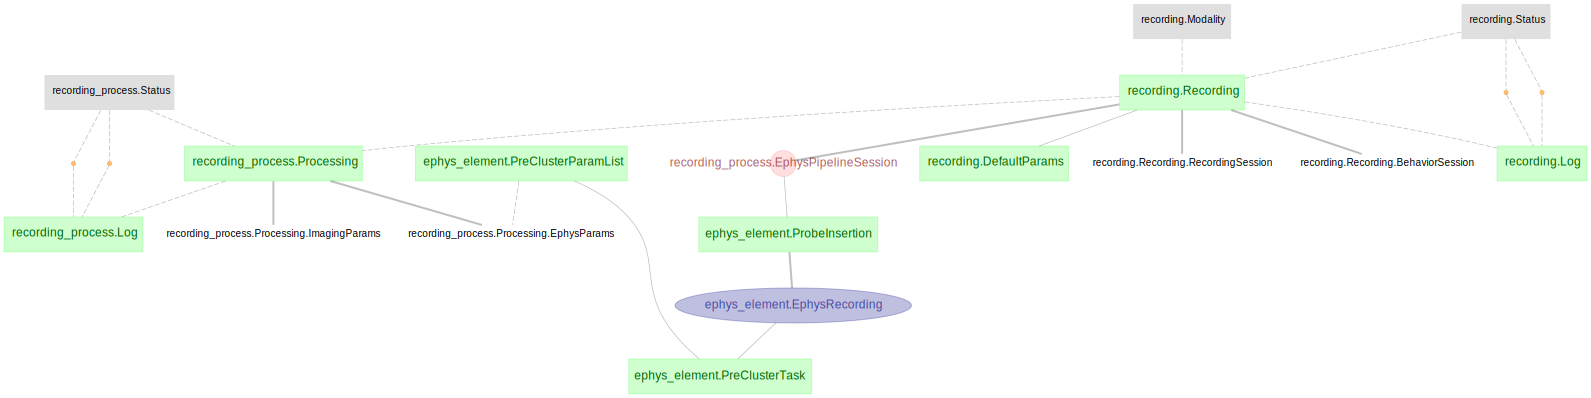

In [4]:
dj.ERD(recording) + dj.ERD(recording_process) + dj.ERD(ephys_pipeline)  + dj.ERD(ephys_element.EphysRecording) + dj.ERD(ephys_element.PreClusterTask) + dj.ERD(ephys_element.PreClusterParamList)


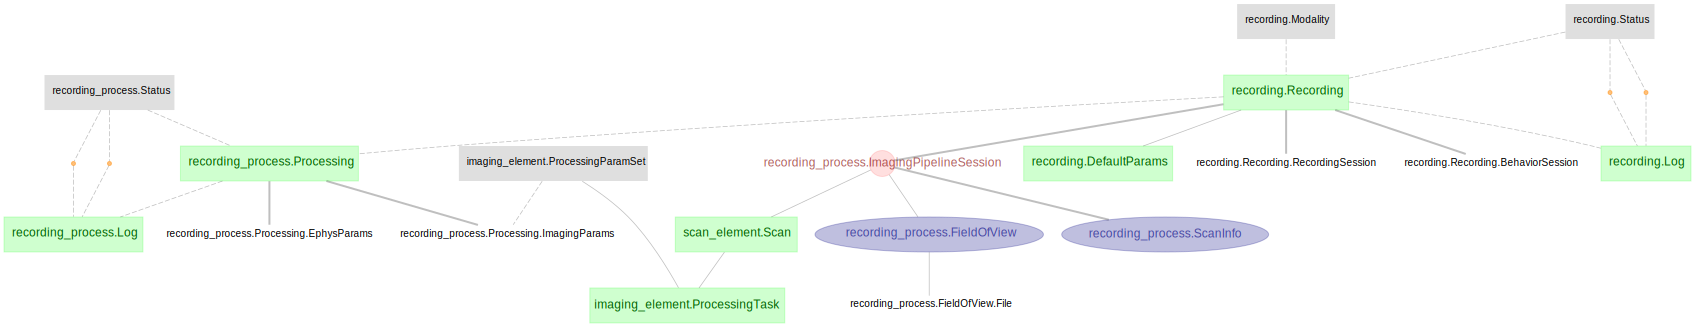

In [6]:
dj.ERD(recording) + dj.ERD(recording_process) + dj.ERD(imaging_pipeline) + dj.ERD(scan_element.Scan) + dj.ERD(imaging_element.ProcessingTask) + dj.ERD(imaging_element.ProcessingParamSet)


# DANGER, delete EphysPipeline tables

In [6]:
ephys_pipeline_db = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')
ephys_pipeline_db.EphysPipelineSession.delete()

,job_id,recording_id,status_processing_id,fragment_number,recording_process_pre_path,recording_process_post_path,task_copy_id_pre,task_copy_id_post,slurm_id
0,56,39,-1,0,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,b5073818-daad-4a46-af50-6ec1519de31f,None,None
1,57,39,-1,1,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
2,58,39,-1,2,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
3,59,40,-1,0,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
4,60,40,-1,1,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
5,61,40,-1,2,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
6,62,40,-1,3,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
7,63,41,-1,0,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
8,64,41,-1,1,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
9,65,41,-1,2,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None


In [4]:
o = b'{\n  "name": "job_id_69_raw_transfer",\n  "start": "2022-05-12T17:56:23+00:00",\n  "stop_after": {\n    "date": "2022-05-13T04:59:59",\n    "n_runs": null\n  },\n  "interval": 259200.0,\n  "callback_url": "https://actions.automate.globus.org/transfer/transfer/run",\n  "callback_body": {\n    "body": {\n      "source_endpoint_id": "6ce834d6-ff8a-11e6-bad1-22000b9a448b",\n      "destination_endpoint_id": "a9df83d2-42f0-11e6-80cf-22000b1701d1",\n      "transfer_items": [\n        {\n          "source_path": "/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec1",\n          "destination_path": "/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec1",\n          "recursive": true\n        }\n      ],\n      "label": "job_id_69_raw_transfer",\n      "encrypt_data": false,\n      "verify_checksum": false,\n      "preserve_timestamp": false,\n      "skip_source_errors": false,\n      "fail_on_quota_errors": false\n    }\n  },\n  "scope": null,\n  "job_id": "002e4e3d-384e-4169-8d0a-3a854c2423a0",\n  "status": "new",\n  "submitted_at": "2022-05-12T17:56:23.978935+00:00",\n  "last_ran_at": null,\n  "next_run": "2022-05-12T17:56:23+00:00",\n  "n_runs": 0,\n  "n_errors": 0,\n  "results": {\n    "data": [],\n    "page_next": null\n  }\n}\n'

In [5]:
from u19_pipeline.automatic_job.clusters_paths_and_transfers import translate_globus_output

o = b'{\n  "name": "job_id_68_raw_transfer",\n  "start": "2022-05-12T19:50:41+00:00",\n  "stop_after": {\n    "date": "2022-05-13T04:59:59",\n    "n_runs": null\n  },\n  "interval": 259200.0,\n  "callback_url": "https://actions.automate.globus.org/transfer/transfer/run",\n  "callback_body": {\n    "body": {\n      "source_endpoint_id": "6ce834d6-ff8a-11e6-bad1-22000b9a448b",\n      "destination_endpoint_id": "a9df83d2-42f0-11e6-80cf-22000b1701d1",\n      "transfer_items": [\n        {\n          "source_path": "/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec0",\n          "destination_path": "/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec0",\n          "recursive": true\n        }\n      ],\n      "label": "job_id_68_raw_transfer",\n      "encrypt_data": false,\n      "verify_checksum": false,\n      "preserve_timestamp": false,\n      "skip_source_errors": false,\n      "fail_on_quota_errors": false\n    }\n  },\n  "scope": null,\n  "job_id": "907600a0-8bef-4e1b-89da-f96f77798ab5",\n  "status": "loaded",\n  "submitted_at": "2022-05-12T19:50:42.010659+00:00",\n  "last_ran_at": "2022-05-12T19:50:46.908797+00:00",\n  "next_run": "2022-05-15T19:50:41+00:00",\n  "n_runs": 1,\n  "n_errors": 0,\n  "results": {\n    "data": [\n      {\n        "data": {\n          "action_id": "bR3Vb7T8F0wY",\n          "completion_time": "2022-05-12T19:50:45.743653+00:00",\n          "creator_id": "urn:globus:auth:identity:a05c014a-be74-4701-9db3-abbb57b57f8c",\n          "details": {\n            "DATA_TYPE": "task",\n            "bytes_checksummed": 0,\n            "bytes_transferred": 0,\n            "canceled_by_admin": null,\n            "canceled_by_admin_message": null,\n            "command": "API 0.10",\n            "completion_time": null,\n            "deadline": "2022-05-13T19:50:46+00:00",\n            "delete_destination_extra": false,\n            "destination_endpoint": "princeton#tigress-dtn",\n            "destination_endpoint_display_name": "Princeton TIGRESS",\n            "destination_endpoint_id": "a9df83d2-42f0-11e6-80cf-22000b1701d1",\n            "directories": 0,\n            "effective_bytes_per_second": 0,\n            "encrypt_data": true,\n            "event_list": [],\n            "fail_on_quota_errors": false,\n            "fatal_error": null,\n            "faults": 0,\n            "files": 0,\n            "files_skipped": 0,\n            "files_transferred": 0,\n            "filter_rules": null,\n            "history_deleted": false,\n            "is_ok": true,\n            "is_paused": false,\n            "label": "Timer job_id_68_raw_transfer, run 1",\n            "nice_status": "OK",\n            "nice_status_details": null,\n            "nice_status_expires_in": 79338,\n            "nice_status_short_description": "OK",\n            "owner_id": "a05c014a-be74-4701-9db3-abbb57b57f8c",\n            "preserve_timestamp": false,\n            "recursive_symlinks": "ignore",\n            "request_time": "2022-05-12T19:50:46+00:00",\n            "skip_source_errors": false,\n            "source_endpoint": "princeton#pni-dtn",\n            "source_endpoint_display_name": "Princeton Neuroscience Institute DTN",\n            "source_endpoint_id": "6ce834d6-ff8a-11e6-bad1-22000b9a448b",\n            "status": "ACTIVE",\n            "subtasks_canceled": 0,\n            "subtasks_expired": 0,\n            "subtasks_failed": 0,\n            "subtasks_pending": 1,\n            "subtasks_retrying": 0,\n            "subtasks_skipped_errors": 0,\n            "subtasks_succeeded": 0,\n            "subtasks_total": 1,\n            "symlinks": 0,\n            "sync_level": null,\n            "task_id": "d0af3abc-d22c-11ec-9ec2-c3c2ad65d825",\n            "type": "TRANSFER",\n            "username": "u_uboacsv6ordqdhntvo5vpnl7rq",\n            "verify_checksum": false\n          },\n          "display_status": "ACTIVE",\n          "label": null,\n          "manage_by": [],\n          "monitor_by": [],\n          "release_after": "P30D",\n          "start_time": "2022-05-12T19:50:45.743590+00:00",\n          "status": "ACTIVE"\n        },\n        "errors": null,\n        "status": 202,\n        "ran_at": "2022-05-12T19:50:46.908797"\n      }\n    ],\n    "page_next": null\n  }\n}\n'
{'DATA_TYPE': 'task', 'bytes_checksummed': 0, 'bytes_transferred': 0, 'canceled_by_admin': None, 'canceled_by_admin_message': None, 'command': 'API 0.10', 'completion_time': None, 'deadline': '2022-05-13T19:50:46+00:00', 'delete_destination_extra': False, 'destination_endpoint': 'princeton#tigress-dtn', 'destination_endpoint_display_name': 'Princeton TIGRESS', 'destination_endpoint_id': 'a9df83d2-42f0-11e6-80cf-22000b1701d1', 'directories': 1, 'effective_bytes_per_second': 0, 'encrypt_data': True, 'fail_on_quota_errors': False, 'fatal_error': None, 'faults': 0, 'files': 4, 'files_skipped': 0, 'files_transferred': 0, 'filter_rules': None, 'history_deleted': False, 'is_ok': True, 'is_paused': False, 'label': 'Timer job_id_68_raw_transfer, run 1', 'nice_status': 'OK', 'nice_status_details': None, 'nice_status_expires_in': 79338, 'nice_status_short_description': 'OK', 'owner_id': 'a05c014a-be74-4701-9db3-abbb57b57f8c', 'preserve_timestamp': False, 'recursive_symlinks': 'ignore', 'request_time': '2022-05-12T19:50:46+00:00', 'skip_source_errors': False, 'source_endpoint': 'princeton#pni-dtn', 'source_endpoint_display_name': 'Princeton Neuroscience Institute DTN', 'source_endpoint_id': '6ce834d6-ff8a-11e6-bad1-22000b9a448b', 'status': 'ACTIVE', 'subtasks_canceled': 0, 'subtasks_expired': 0, 'subtasks_failed': 0, 'subtasks_pending': 5, 'subtasks_retrying': 0, 'subtasks_skipped_errors': 0, 'subtasks_succeeded': 1, 'subtasks_total': 6, 'symlinks': 0, 'sync_level': None, 'task_id': 'd0af3abc-d22c-11ec-9ec2-c3c2ad65d825', 'type': 'TRANSFER', 'username': 'u_uboacsv6ordqdhntvo5vpnl7rq', 'verify_checksum': False}

{'DATA_TYPE': 'task',
 'bytes_checksummed': 0,
 'bytes_transferred': 0,
 'canceled_by_admin': None,
 'canceled_by_admin_message': None,
 'command': 'API 0.10',
 'completion_time': None,
 'deadline': '2022-05-13T19:50:46+00:00',
 'delete_destination_extra': False,
 'destination_endpoint': 'princeton#tigress-dtn',
 'destination_endpoint_display_name': 'Princeton TIGRESS',
 'destination_endpoint_id': 'a9df83d2-42f0-11e6-80cf-22000b1701d1',
 'directories': 1,
 'effective_bytes_per_second': 0,
 'encrypt_data': True,
 'fail_on_quota_errors': False,
 'fatal_error': None,
 'faults': 0,
 'files': 4,
 'files_skipped': 0,
 'files_transferred': 0,
 'filter_rules': None,
 'history_deleted': False,
 'is_ok': True,
 'is_paused': False,
 'label': 'Timer job_id_68_raw_transfer, run 1',
 'nice_status': 'OK',
 'nice_status_details': None,
 'nice_status_expires_in': 79338,
 'nice_status_short_description': 'OK',
 'owner_id': 'a05c014a-be74-4701-9db3-abbb57b57f8c',
 'preserve_timestamp': False,
 'recursive

In [7]:
import json

s = o.decode("UTF-8")

u = json.loads(s)

u


{'name': 'job_id_68_raw_transfer',
 'start': '2022-05-12T19:50:41+00:00',
 'stop_after': {'date': '2022-05-13T04:59:59', 'n_runs': None},
 'interval': 259200.0,
 'callback_url': 'https://actions.automate.globus.org/transfer/transfer/run',
 'callback_body': {'body': {'source_endpoint_id': '6ce834d6-ff8a-11e6-bad1-22000b9a448b',
   'destination_endpoint_id': 'a9df83d2-42f0-11e6-80cf-22000b1701d1',
   'transfer_items': [{'source_path': '/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec0',
     'destination_path': '/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec0',
     'recursive': True}],
   'label': 'job_id_68_raw_transfer',
   'encrypt_data': False,
   'verify_checksum': False,
   'preserve_timestamp': False,
   'skip_source_errors': False,
   'fail_on_quota_errors': False}},
 'scope': None,
 'job_id': '907600a0-8bef-4e1b-89da-f96f77798ab5',
 'status': 'loaded',
 'subm

'{  "name": "job_id_69_raw_transfer",  "start": "2022-05-12T17:56:23+00:00",  "stop_after": {    "date": "2022-05-13T04:59:59",    "n_runs": null  },  "interval": 259200.0,  "callback_url": "https://actions.automate.globus.org/transfer/transfer/run",  "callback_body": {    "body": {      "source_endpoint_id": "6ce834d6-ff8a-11e6-bad1-22000b9a448b",      "destination_endpoint_id": "a9df83d2-42f0-11e6-80cf-22000b1701d1",      "transfer_items": [        {          "source_path": "/mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec1",          "destination_path": "/tiger/scratch/gpfs/BRAINCOGS/Data/Raw/electrophysiology/ms81/ms81_M005/20210508/towersTask_g0/towersTask_g0_imec1",          "recursive": true        }      ],      "label": "job_id_69_raw_transfer",      "encrypt_data": false,      "verify_checksum": false,      "preserve_timestamp": false,      "skip_source_errors": false,      "fail_on_quota_errors": false    }  },  "scope": 